In [2]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from scipy import stats
import math
from typing import List, Tuple, Any
import sqlite3
import os

In [22]:
def plot_database_columns(test_name, x_column, y_column, table_name, z_column=None, focus=None):
    """
    Create a scatter plot from two columns in a SQLite database table.
    
    Parameters:
    database_path (str): Path to the SQLite database file
    x_column (str): Name of the column to plot on x-axis
    y_column (str): Name of the column to plot on y-axis
    table_name (str): Name of the table in the database
    z_column (str, optional): Name of column to filter on
    focus (list, optional): List of values to filter z_column by
    """
    database_path = os.path.join("Databases", f"database_{test_name}.db")
    try:
        # Use context manager for database connection
        with sqlite3.connect(database_path) as conn:
            cursor = conn.cursor()
            
            # Create a query to select the desired columns with optional filtering
            if z_column and focus:
                # Convert the focus list to string for SQL IN clause
                focus_str = ', '.join('?' * len(focus))
                # No need for separate column selection if column_z is x_column or y_column
                query = f"""
                    SELECT DISTINCT {x_column}, {y_column}
                    FROM {table_name}
                    WHERE {z_column} IN ({focus_str})
                """
                # Execute with parameters
                cursor.execute(query, focus)
            else:
                query = f"SELECT {x_column}, {y_column} FROM {table_name}"
                cursor.execute(query)
            
            results = cursor.fetchall()
            
            if not results:
                print("No data found matching the specified criteria.")
                return
        
        # Convert results directly to numpy arrays
        x_array = np.array([float(row[0]) for row in results])
        y_array = np.array([float(row[1]) for row in results])
        
        # Calculate regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_array, y_array)
        
        # Create points for regression line
        line_x = np.array([x_array.min(), x_array.max()]).reshape(-1, 1)
        line_y = slope * line_x + intercept
        
        print(f'Regression line\ny = {slope:.4f}x + {intercept:.4f}\nR² = {r_value**2:.4f}\np value = {p_value}\nstd_error = {std_err}')
        
        # Create the scatter plot
        plt.figure(figsize=(8, 4))
        plt.scatter(x_array, y_array, alpha=0.5)
        
        # Plot regression line
        plt.plot(line_x, line_y, 'r-', label="Regression line")
                #label=f'Regression line\ny = {slope:.4f}x + {intercept:.4f}\nR² = {r_value**2:.4f}\np value = {p_value}\nstd_error = {std_err}')
        
        # Customize the plot
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        title = f'{y_column} vs {x_column} from {table_name}'
        if z_column and focus:
            title += f'\n(filtered {z_column} = {focus})'
        plt.title(title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        # Show the plot
        plt.show()
        
    except sqlite3.Error as e:
        print(f"Database error: {e}")
    except Exception as e:
        print(f"Error: {e}")

Regression line
y = 16.4788x + -262.5793
R² = 0.4317
p value = 6.816690737830966e-08
std_error = 2.6220193069218007


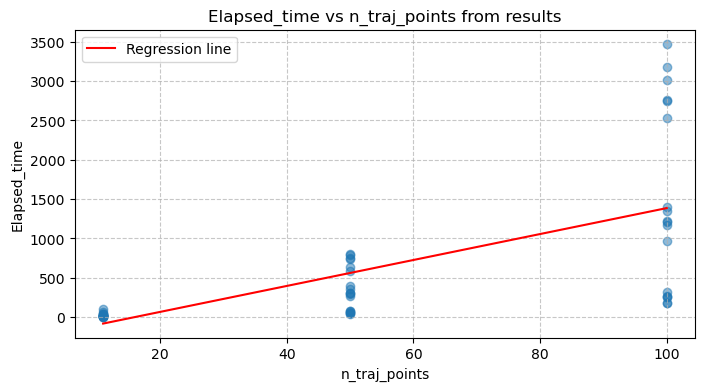

In [45]:
test_name = "New_everything"
x_column = "n_traj_points"
y_column = "Elapsed_time"
table_name = "results"

z_column = None#"n_traj_points"
focus = [11, 50]

plot_database_columns(test_name, x_column, y_column, table_name, z_column=z_column, focus=focus)

Regression line
y = 0.0873x + 384.2315
R² = 0.0451
p value = 0.027326555902642914
std_error = 0.03902088477461958


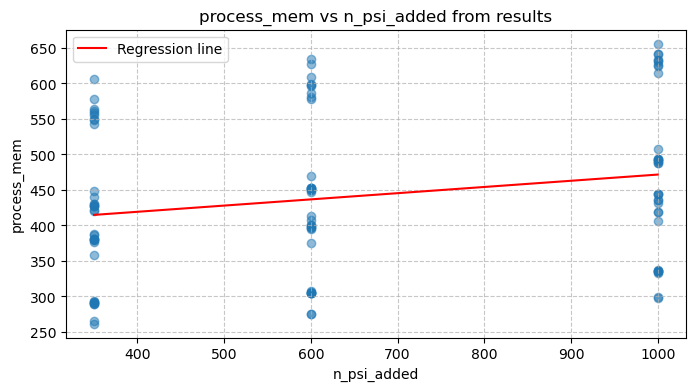

Regression line
y = 0.0942x + 205.5824
R² = 0.9150
p value = 1.496956594648832e-58
std_error = 0.002788155304606998


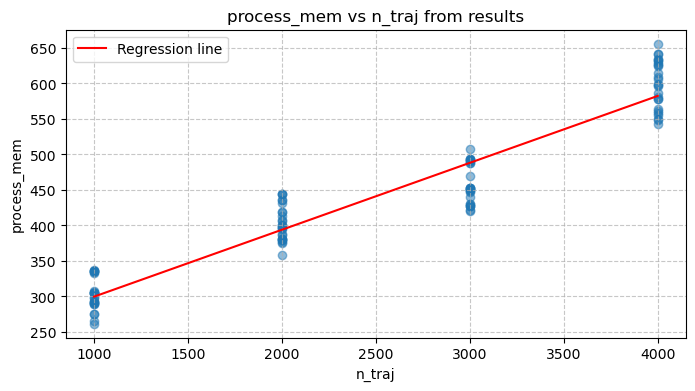

Regression line
y = -19.5478x + 456.6280
R² = 0.0008
p value = 0.7657273602260469
std_error = 65.43531519545456


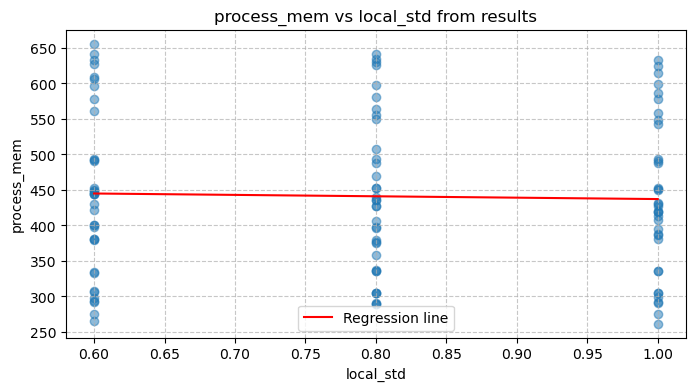

Regression line
y = 0.1459x + 436.1740
R² = 0.0006
p value = 0.8067098315414416
std_error = 0.5949480407605025


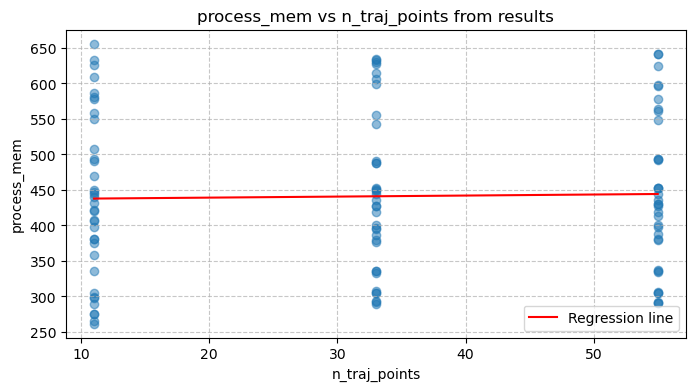

In [60]:
#['n_psi_added', 'n_traj', 'local_std', 'n_traj_points', 'Dist', 'Cos_Dist', 'Dist_rho', 'Norm_glob', 'Norm_loc', 'Norm_imp', 'Pinv_error', 'Sum_weights', 'Sum_squared_weights', 'Elapsed_time', 'Process_mem']

test_name = "one"
y_column = "process_mem"
table_name = "results"
params = ["n_psi_added", "n_traj", "local_std", "n_traj_points"]

z_column = None#"n_traj_points"
focus = None#[33, 55]

for x_column in params:
    plot_database_columns(test_name, x_column, y_column, table_name, z_column=z_column, focus=focus)